<div align=center>
		
<p></p>
<p></p>
<font size=5>
In the Name of God
<font/>
<p></p>
 <br/>
    <br/>
    <br/>
<font color=#FF7500>
Sharif University of Technology - Departmenet of Computer Engineering
</font>
<p></p>
<font color=blue>
Artifical Intelligence - Dr. Mohammad Hossein Rohban
</font>
<br/>
<br/>
Fall 2021

</div>

<hr/>
		<div align=center>
		    <font color=red size=6>
			    <br />
Practical Assignment 4 Pytorch Classification
            	<br/>
			</font>
    <br/>
    <br/>
<font size=4>
                <br/><b>
              Cheating is Strongly Prohibited
                </b><br/><br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

# Personal Data

In [ ]:
# Set your student number
student_number = 98100118
Name = 'parham'
Last_Name = 'chavoshian'

# Rules
- You **are** allowed to add or remove cells. 
- By running the cell below, you can see if your jupyter file is accepted or not. This cell will also **generate a python file which you'll have to upload to Quera** (as well as your jupyter file). The python file will later be validated and if the code in both files doesn't match, **your Practical Assignment won't be graded**.

In [ ]:
# remember to save your jupyter file before running this script
from Helper_codes.validator import *

python_code = extract_python("./Q2.ipynb")
with open(f'python_code_Q2_{student_number}.py', 'w') as file:
    file.write(python_code)

your file will be graded


# PyTorch & MNIST Classification (50 points+5 Extra)

<font size=4>
Author: Arman Zarei
			<br/>
                <font color=red>
Please run all the cells.
     </font>
</font>
                <br/>
    </div>

In this assignment, you are going to learn the fundamentals of PyTorch and implement a classifier network for MNIST dataset. You can read about more details of PyTorch components from [this link](https://pytorch.org/tutorials).

### Setup

In [2]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import os
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
from ae_helper import init_mnist_subset_directories
import copy
import time
import torch.optim as optim

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

#### Loading dataset

In [3]:
mnist_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## Autograd

Autograd is PyTorch's automatic differentiation engine that powers neural network training. In essence it helps us to calculate derivatives and updating parameters. To read more about Autograd and Computational Graph visit [this link](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

Let us define two parameters: $p_1$ and $p_2$. 

In [4]:
p1 = torch.tensor([3.], requires_grad=True)
p2 = torch.tensor([7.], requires_grad=True)

Now define a variable $L$ as below:

$L = 3 \times p_1^3 - 7 \times p_2^2 + sin(p1) \times p_2^2$

In [5]:
# Place your code here (2.5 Points)
## Hint: You can use torch.sin for calculation of sin(p1)
L = (3 * (p1 ** 3)) - (7 * (p2 ** 2)) + (torch.sin(p1) * (p2 ** 2))


Now you have to calculate the gradient of $p_1$ and $p_2$ with respect to $L$. First do it by hand and write the mathematical expression in the below cell both for $p_1$ and $p_2$. Then evaluate them at $3$ and $7$ (acording to the initialization)

Place your expressions here **(2.5 Points)**


$\frac{dL}{dp_1} = 9 \times p_1^2 + cos(p1) \times p_2^2$

$\frac{dL}{dp_2} = -14 \times p_2 + 2 \times p_2 \times sin(p_1)$

$\frac{dL}{dp_1}(3, 7) = 32.49 $

$\frac{dL}{dp_2}(3, 7) =  -96.02$

In [6]:
# Place your code here (optional)
## For calculation of dL/dp in the given point
print((9 * (p1 ** 2)) + (torch.cos(p1) * (p2 ** 2)))
print((-14 * p2) + (2 * p2  *torch.sin(p1)))

tensor([32.4904], grad_fn=<AddBackward0>)
tensor([-96.0243], grad_fn=<AddBackward0>)


Now let's calculate this using pytorch. The below code will construct the computational graph and stores the gradient of each variable inside of it.

In [7]:
L.backward()

Check whether the result of your calculations is the same with the autograd's output.

In [8]:
print(f"P_1 grad: {p1.grad.item()}\nP_2 grad: {p2.grad.item()}")

P_1 grad: 32.4903678894043
P_2 grad: -96.02432250976562


## Transform 

Data does not always come in its final processed form that is required for training machine learning algorithms. We use transforms to perform some manipulation of the data and make it suitable for training. For more details, you can read [this link](https://pytorch.org/vision/stable/transforms.html)

There are many transformations that are already implemented inside pytorch that you can use. Here we are going to implement some transformation from scratch using PyTorch's framework.

#### Random Horizontal Flip Transformation

Define a transformation that flips the image (horizontally) with probability of $p$. In order to implement a simple transformation class, you need to have two methods: `__init__` and `__call__` (which receives the image)

In [9]:
class RandomHorizontalFlip(object):
    def __init__(self, p=0.5):
    # Place your code here (2 Points)
      self.p = p
    pass
  
    def __call__(self, x):
    # Place your code here (3 Points)
      if torch.rand(1)[0] < self.p:
        return torch.flip(x, [2,])
      return x

#### Random Color Swap

Now that you have learned how to implement a transformation class, let's build another one. Define a transformation which swaps the colors (in the gray scale image) with probability of $p$. For example, if the given image had a white colored number with a black background, it should output an image with black colored number and a white background.

**Hint:** for a given input $x$, you can concider the swapped color version of it as $x_{new} = m - x$ where $m$ is the maximum value in image $x$

In [11]:
# Place your code here (5 Points)
class RandomColorSwap(object):
    def __init__(self, p=0.5):
    # Place your code here (2 Points)
      self.p = p
    pass
  
    def __call__(self, x):
    # Place your code here (3 Points)
      if torch.rand(1)[0] < self.p:
        return torch.max(x) - x
      return x

### Evaluation of transformations

Now, let's apply these transformations on some images of our dataset. You can stack different transformation using `Compose`

In [12]:
trans = transforms.Compose([
  RandomHorizontalFlip(p=0.7),
  RandomColorSwap()
])

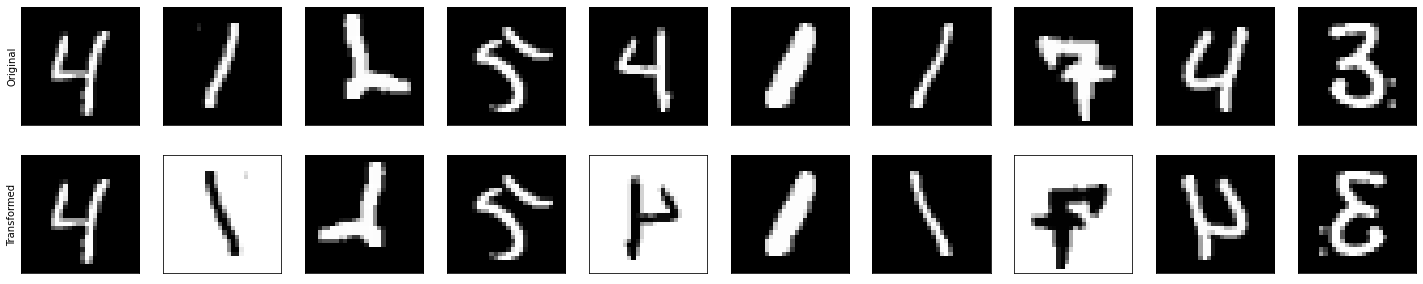

In [23]:
num_imgs = 10
fig, axs = plt.subplots(2, num_imgs, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, len(mnist_dataset), [num_imgs])):
    x, y = mnist_dataset[idx]
    axs[0, i].imshow(x[0], cmap='gray')
    axs[1, i].imshow(trans(x)[0], cmap='gray')
    for k in range(2):
        axs[k, i].set_yticks([])
        axs[k, i].set_xticks([])

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Transformed");

What we expect to see is that, some of them are fliped horizontally, some swapped in color, and some both.

## Dataset

In this section, we are going to implement a dataset class. Inside `torchvision.datasets` there are many Datasets that are already implemented and ready to use. But, in many situations it's necessary to implement one by your self.

Run the below cell to initialize our dataset

In [16]:
dataset_path = "new_mnist"
init_mnist_subset_directories(mnist_dataset, dataset_path)

100%|██████████| 5000/5000 [00:01<00:00, 2683.56it/s]


If you take a look at `new_mnist` directory which is created in the directory you are working in, you see that it contains 10 folders with names from `0` to `9` indicating the label of the images inside it. Inside each, some files with name `data_{number}.pth` exist. Each `.pth` file is an image.

Now you have to implement a Dataset on top of these files.
The methods that you should implement in a Dataset (as you can see in the code) is as described below:
- `__init__`: In our example assume that it only accepts `root_dir` and `transform` as it's parameters (You should apply the transformations before outputing the data)
- `__len__`: Should return the number of data in your dataset
- `__getitem__`: which receives an index, should return the data at the given index (which is a tuple here, containing image and the corresponding label) 

In [25]:
class MNISTDataset(Dataset):
    def __init__(self, root_dir, transform):
        # Place your code here (4 Points)
        ## Hint: Use os.listdir(some_path) to get the list of files
        self.images = []
        self.labels = []
        self.len = 0
        folders = sorted(list(os.listdir(root_dir)))
        for folder in folders:
          files = sorted(list(os.listdir(root_dir + '/' + folder)))
          for file in files:
            self.images.append(transform(torch.load(root_dir + '/' + folder + '/' + file)))
            self.labels.append(folder)
            self.len += 1

        
        pass

    def __len__(self):
        # Place your code here (1 Points)
        return self.len
        pass

    def __getitem__(self, idx):
        # Place your code here (3 Points)
        ## Return a tuple (image, label)
        return (self.images[idx], self.labels[idx])
        pass

After you defined your dataset, let's use it.

In [27]:
my_dataset = MNISTDataset(root_dir=dataset_path, transform=RandomColorSwap())
len(my_dataset)

5000

Visualize 10 samples (randomely) from your dataset with their labels

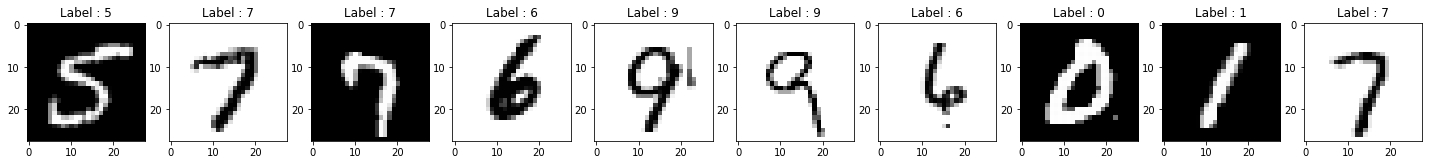

In [45]:
# Place your code here (2 Points)
num_imgs = 10
fig, axs = plt.subplots(1, 10, figsize=(25, 5))
for i, idx in enumerate(torch.randint(0, 5000, [num_imgs])):
    x, y = my_dataset.__getitem__(idx)
    image = torch.Tensor.numpy(x).reshape((28, 28))
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title('Label : ' + y)


## MNIST Classification

### Model
Define your model (Based on what you have learned in the workshop). I highly encourage you to try different models with different layers in order to achieve a better accuracy

**Notice:** You cannot use convolution layers in your model 

In [4]:
# Place your code here (5 points)
class DigitRecognizer(nn.Module):
    def __init__(self):
      super().__init__()
      self.bn1 = nn.BatchNorm2d(num_features=1)
      self.bn2 = nn.BatchNorm1d(num_features=60)
      self.bn3 = nn.BatchNorm1d(num_features=30)
      self.fc1 = nn.Linear(28 * 28, 400)
      self.fc2 = nn.Linear(400, 120)
      self.fc3 = nn.Linear(120, 60)
      self.fc4 = nn.Linear(60, 30)
      self.fc5 = nn.Linear(30, 10)
      self.relu  = nn.ReLU()
      self.sm = nn.Sigmoid()
    
    def forward(self, x):
      x = self.bn1(x)
      x = x.reshape(x.shape[0], -1)
      x = self.fc1(x)
      x = self.relu(x)
      x = self.fc2(x)
      x = self.relu(x)
      x = self.fc3(x)
      x = self.bn2(x)
      x = self.relu(x)
      x = self.fc4(x)
      x = self.relu(x)
      x = self.bn3(x)
      x = self.fc5(x)
      return self.sm(x)

In [5]:
model = DigitRecognizer().to(device)
model

DigitRecognizer(
  (bn1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=60, bias=True)
  (fc4): Linear(in_features=60, out_features=30, bias=True)
  (fc5): Linear(in_features=30, out_features=10, bias=True)
  (relu): ReLU()
  (sm): Sigmoid()
)

### Dataset and Dataloader

Prepare datasets and dataloader for train/test. We use MNIST dataset that is already implemented inside `torchvision.datasets`.

 You need to split the `mnist_dataset` into `train_dataset` and `val_dataset`. 
 
 You can also define more transformations that you think it would help the training process **(Optional)**.

In [6]:
transform_compose = transforms.Compose([
    transforms.ToTensor(),
    # Place your code here
])

mnist_dataset = datasets.MNIST(root='dataset', train=True, download=True, transform=transform_compose)
# Place your code here (1 points)
## Notice: Split mnist_dataset into train_dataset and val_dataset
torch.seed()
train_dataset, val_dataset = torch.utils.data.random_split(mnist_dataset, [50000, 10000])

# End of block for your code placement
test_dataset = datasets.MNIST(root='dataset', train=False, download=True, transform=transforms.ToTensor())

train_batch_size = 32
val_batch_size = 16
test_batch_size = 16
datalaoders = {'train' : DataLoader(dataset=train_dataset, batch_size=train_batch_size, shuffle=True, num_workers=1),
               'val' : DataLoader(dataset=val_dataset, batch_size=val_batch_size, shuffle=False, num_workers=1)}
test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch_size, shuffle=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



### Criterion and Optimizer

you have to tune the `learning_rate` yourself (Based on your training process)

In [7]:
learning_rate = 0.00095
gamma = 0.997
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma)

### Train your model

Write your training/validation loop in the following cell for an arbitrary number of epochs (until convergence is detected). You also need to store train/validation loss at each epoch in order to visualize them the after training is done.

In [8]:
epochs = 15
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10
model_name = 'my_MNIST'  
history = {'train': [], 'val': []}
for epoch in range(epochs):
    print('\n\nEpoch {}/{}'.format(epoch + 1, epochs))
    print('-' * 10)
        
    since = time.time()
    for phase in ['train', 'val']:
        if phase == 'train':
            for param_group in optimizer.param_groups:
                print("LR", param_group['lr'])
            model.train()
        else:
            model.eval()

        epoch_loss = 0
        for b, (inputs, labels) in enumerate(datalaoders[phase]):
            inputs = inputs.to("cuda" if torch.cuda.is_available() else "cpu")
            labels = labels.to("cuda" if torch.cuda.is_available() else "cpu")

            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss += loss.item() * eval(phase + '_batch_size')
                if phase == 'train':
                    loss.backward()
                    optimizer.step()
        epoch_loss /= len(datalaoders[phase].dataset)
        print(phase + " loss: {:4f}".format(epoch_loss))
        history[phase].append(epoch_loss)
        if phase == 'train':
            scheduler.step()
            
        if phase == 'val' and epoch_loss < best_loss:
            print("saving best model")
            best_loss = epoch_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            torch.save({'epoch': epoch + 1, 
                        'model': model.state_dict(), 
                        'optimizer' : optimizer.state_dict(),
                        'scheduler' : scheduler.state_dict()},
                         model_name + '_best.pth.tar'.format(epoch + 1))
            
    time_elapsed = time.time() - since
    print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # model.train()
    # Place your code here (5 points)
    ## Hint: Loop throught train_loader, get images with their labels and train the model
    ## Hint 2: To update train_loss inside the loop use "train_loss += batch_loss * batch_size""
  
  
    # model.eval()
    # Place your code here (4 points)
    ## Hint: Loop throught val_loader, get images with their labels and evaluate the model
    ## Hint 2: To update val_loss inside the loop use "val_loss += batch_loss * batch_size""
    



Epoch 1/15
----------
LR 0.00095
train loss: 1.593883
val loss: 1.494185
saving best model
0m 19s


Epoch 2/15
----------
LR 0.00094715
train loss: 1.493405
val loss: 1.484526
saving best model
0m 20s


Epoch 3/15
----------
LR 0.00094430855
train loss: 1.485457
val loss: 1.485139
0m 20s


Epoch 4/15
----------
LR 0.00094147562435
train loss: 1.481203
val loss: 1.482742
saving best model
0m 20s


Epoch 5/15
----------
LR 0.0009386511974769499
train loss: 1.478468
val loss: 1.482139
saving best model
0m 19s


Epoch 6/15
----------
LR 0.0009358352438845191
train loss: 1.476582
val loss: 1.480835
saving best model
0m 19s


Epoch 7/15
----------
LR 0.0009330277381528656
train loss: 1.474187
val loss: 1.478602
saving best model
0m 19s


Epoch 8/15
----------
LR 0.000930228654938407
train loss: 1.473192
val loss: 1.478967
0m 19s


Epoch 9/15
----------
LR 0.0009274379689735917
train loss: 1.471682
val loss: 1.479432
0m 20s


Epoch 10/15
----------
LR 0.000924655655066671
train loss: 1.4710

#### Plot train/validation loss

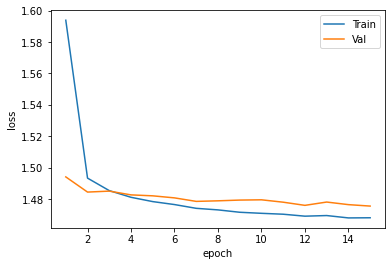

In [9]:
# Place your code here (1 points)
plt.plot(range(1, 16), history['train'], label='Train');
plt.plot(range(1, 16), history['val'], label='Val');
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend();
plt.show();

### Evaluation

Evaluate your model on test set. you have to report both loss and accuracy.

In order to get the full score of this section, you need to achieve an accuracy above $95\%$ and to get the extra points, your accuracy should be above $98\%$ 

**Notice:** You should use test set only for evaluation of your model.

In [10]:
# Place your code here (4 points + 5 Extra)
best_model = DigitRecognizer().to(device)
best_model.load_state_dict(best_model_wts)
for param in best_model.parameters():
    param.requires_grad = False

best_model.eval()

correct = 0
total = 0
i = 0
wrong_samples = []
wrong_preds = []
wrong_labels = []
with torch.no_grad():
    test_loss = 0
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = best_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * test_batch_size
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if i < 8:
          for j in (predicted != labels).nonzero().reshape(-1):
            if i >= 8:
              break
            wrong_samples.append(inputs[j]) 
            wrong_preds.append(predicted[j])
            wrong_labels.append(labels[j])
        test_loss /= len(test_loader)
    print('Test Loss = {:4f}'.format(test_loss))
    print('Test Accuracy: %4f%%' % (100 * correct / total))

Test Loss = 0.037466
Test Accuracy: 98.120000%


### Visualization of wrong prediction

Visualize $8$ samples (along with original label and model's prediction) from test set which are labeled wrong by your model

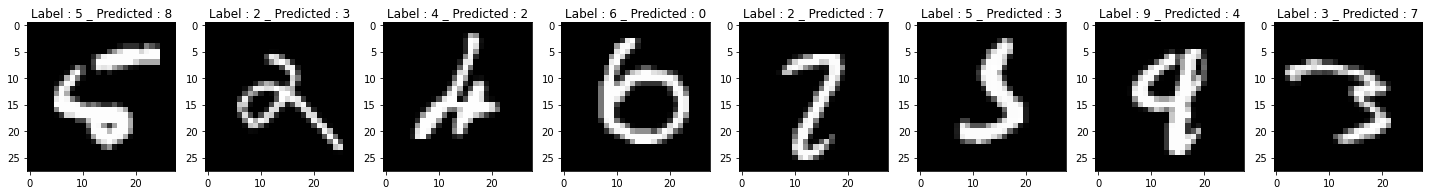

In [24]:
# Place your code here (5 points)
fig, axs = plt.subplots(1, 8, figsize=(25, 5))
for i in range(8):
    image = wrong_samples[i].detach().cpu().numpy().reshape((28, 28))
    axs[i].imshow(image, cmap='gray')
    axs[i].set_title('Label : ' + str(wrong_labels[i].item()) + ' _ Predicted : ' + str(wrong_preds[i].item()))
